# Analysis 5e - Run simulations, visualize phase space and plot scatter plots to intuitively see correlations

## Provide a direct relationship between FC and the eigenvalues of the Jacobian

## Includes linear stability analysis at fixed points

## Include transformation to BOLD signal

#### Taku Ito
#### 11/30/2018

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import seaborn as sns
import pandas as pd
plt.style.use('ggplot')
sns.set_style('whitegrid')
import scipy.signal as signal
import os
os.sys.path.append('../')
import BalloonWindkessel as bw

# 1.0 Define functions

Let $x_1$ be an excitatory neuron. Let $x_2$ be an inhibitory neuron. Define $w_ij$ to be the weight from neuron $x_i$ to $x_j$.

To identify the rate of change for the firing rates for these neuronal populations, we have

$$\tau_1 \frac{dx_1}{dt} = -x_1 + f\Big( w_{11} x_1 + w_{21} x_2 + b_1 + s_1 \Big) \qquad \qquad (2)$$

$$\tau_2 \frac{dx_2}{dt} = -x_2 + f\Big( w_{12} x_1 + w_{22} x_2 + b_2 + s_2 \Big) \qquad \qquad (3)$$

Where $f(x)$ refers to the nonlinear function defined above, $\tau_i$ refers to the time constant of neuron $i$, and $s_i$ is the gain on neuron $i$.


# Need to fix below equations

### 2.1 - Phase Portraits and Nullclines for $x_1$ and $x_2$ 

Mathematical formula for $x_1$ nullcline:
$$ x_2 = \frac{f^{-1} ( -x_1 ) - w_{11} x_1 - b_1 - s_1}{w_{21}} $$

Mathematical formula for $x_2$ nullcline:
$$ x_1 = \frac{f^{-1} ( -x_2 ) - w_{22} x_2 - b_2 - s_2}{-w_{12}} $$

## 2.2 - Jacobian matrix

The *Jacobian* $J$ is defined by
$$
 J = \left( \begin{array}{cc}
\big(-1 + f'(w_{11} x_1 + w_{21}x_2 + b_1 + s_1)\big) \frac{1}{\tau_1} & \big(f'( w_{11} x_1 + w_{21} x_2 + b_1 + s_1)\big) \frac{1}{\tau_1} \\
\big( f'(w_{22} x_2 + w_{12} x_1 + b_2 + s_2)\big)\frac{1}{\tau_2} & \big(-1 + f'(w_{22} x_2 + w_{12} x_1 + b_2 + s_2)\big)\frac{1}{\tau_2} \end{array} \right) $$

In [5]:
def sigmoid(x):
#     return np.tanh(x)
    return 1/(1+np.exp(-.5*x))

def dxdtSigmoid(x):
    return np.exp(x)/((np.exp(x)+1)**2)
#     return x - np.log(np.exp(x) + 1)

def invsigmoid(x):
    return 2*np.log((x)/(1-(x)))


def runSim(w11,w12,w22,w21,d1,d2,b1,b2,s1,s2,t,xinit1,xinit2,tau1,tau2,dt=.1):
    I1 = np.zeros((t,))
    I2 = np.zeros((t,))
    # Set initial conditions
    I1[0] = xinit1
    I2[0] = xinit2
    
    for i in range(1,t):
        i1k1 = -I1[i-1] + sigmoid(w11*I1[i-1]+w21*I2[i-1]+b1+d1[i-1]+s1[i-1]) 
        i1k1 = i1k1/tau1
        i2k1 = -I2[i-1] + sigmoid(w22*I2[i-1]+w12*I1[i-1]+b2+d2[i-1]+s2[i-1]) 
        i2k1 = i2k1/tau2
        
        i1a = I1[i-1] + i1k1*dt
        i2a = I2[i-1] + i2k1*dt
        
        i1k2 = -i1a + sigmoid(w11*i1a+w21*i2a+b1+d1[i]+s1[i])
        i1k2 = i1k2/tau1
        i2k2 = -i2a + sigmoid(w22*i2a+w12*i1a+b2+d2[i]+s2[i]) 
        i2k2 = i2k2/tau2
        
        I1[i] = I1[i-1] + dt*((i1k1+i1k2)/2)
        I2[i] = I2[i-1] + dt*((i2k1+i2k2)/2)
        
    return I1[25:], I2[25:]

def findFP(w11,w12,w22,w21,b1,b2,s1,s2,t,xinit1,xinit2,tau1,tau2,dt=.1):
    """
    Finds the fixed point of the model for a particular parameter regime
    """
    I1 = np.zeros((t,))
    I2 = np.zeros((t,))
    # Set initial conditions
    I1[0] = xinit1
    I2[0] = xinit2
    
    for i in range(1,t):
        i1k1 = -I1[i-1] + sigmoid(w11*I1[i-1]+w21*I2[i-1]+b1+s1) 
        i1k1 = i1k1/tau1
        i2k1 = -I2[i-1] + sigmoid(w22*I2[i-1]+w12*I1[i-1]+b2+s2) 
        i2k1 = i2k1/tau2
        
        i1a = I1[i-1] + i1k1*dt
        i2a = I2[i-1] + i2k1*dt
        
        i1k2 = -i1a + sigmoid(w11*i1a+w21*i2a+b1+s1)
        i1k2 = i1k2/tau1
        i2k2 = -i2a + sigmoid(w22*i2a+w12*i1a+b2+s2) 
        i2k2 = i2k2/tau2
        
        I1[i] = I1[i-1] + dt*((i1k1+i1k2)/2)
        I2[i] = I2[i-1] + dt*((i2k1+i2k2)/2)
        
        if I1[i] == I1[i-1] and I2[i] == I2[i-1]: 
            I1fp = I1[i] 
            I2fp = I2[i]
            break        
        
    return I1fp, I2fp

def computeJacobian(fpx1,fpx2,w11,w22,w12,w21,b1,b2,s1,s2,tau1,tau2):
    j11 = (-1 + dxdtSigmoid(w11*fpx1+w21*fpx2+b1+s1))/tau1
    j12 = (dxdtSigmoid(w11*fpx1+w21*fpx2+b1+s1))/tau1
    j21 = (dxdtSigmoid(w22*fpx2+w12*fpx1+b2+s2))/tau2
    j22 = (-1 + dxdtSigmoid(w22*fpx2+w12*fpx1+b2+s2))/tau2
    Jacobian = np.zeros((2,2))
    Jacobian[0,0] = j11
    Jacobian[0,1] = j12
    Jacobian[1,0] = j21
    Jacobian[1,1] = j22
    return Jacobian


def nullclineI1(w11,w21,d1,I1,b1,s1,b2):
    pos_ind = np.where(I1>0)[0]
    invx1 = invsigmoid(I1[pos_ind])
    nI1 = (invx1 - w11*I1[pos_ind] - b1 - s1)/w21
    I1 = I1[pos_ind]
    return nI1, I1

def nullclineI2(w22,w12,d2,I2,b2,s2,b1):
    pos_ind = np.where(I2>0)[0]
    invx2 = invsigmoid(I2[pos_ind])
    nI2 = (invx2 - w22*I2[pos_ind] - b2 - s2)/w12
    I2 = I2[pos_ind]
    return nI2, I2

from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi


Text(0.5,0,'Input')

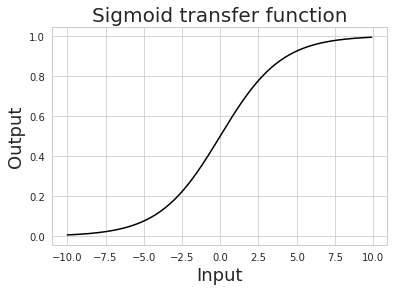

In [6]:
# Set connectivity weights
w11 = 2
w22 = 2
w12 = 4
w21 = 4


# Set biases
b1 = -3
b2 = -3
# Set time constants
tau1 = .1
tau2 = .1

x = np.arange(-10,10,.1)
plt.plot(x,sigmoid(x),'k')
plt.title('Sigmoid transfer function', fontsize=20)
plt.ylabel('Output',fontsize=18)
plt.xlabel('Input',fontsize=18)
# plt.savefig('SigmoidNegativeBias.pdf')

# 2.0 Run simulations

## 2.1 Sweep across different stimulation amplitudes
### 2.1.1 Relate eigenvalues at fixed point with correlations

In [11]:
# Set n timepoints
t = 10025

# d1 = np.zeros((t,))
# d2 = np.zeros((t,))
correlation_values = []
correlation_bold = []
rankcorr_values = []
rankcorr_bold = []
eigenvalue_proportion = []
sd_values = []
pspectrum = []
vectorsums = []
pspectrum2 = []
mutualinfo = []
jointentropy = []
stim_range = np.arange(-5,5.01,.1)
for s in stim_range:
    d1 = np.random.normal(0,1.0,(t,))
    d2 = np.random.normal(0,1.0,(t,))
    s1 = s
    s2 = s
    s1vec = np.ones((t,))*s1
    s2vec = np.ones((t,))*s2
    # Set stimulation only to region 1
    # s1[stimOnset:stimOffset] = 0

    # Calculate fixed points
    xinit1 = 0
    xinit2 = 0
    I1fp, I2fp = findFP(w11,w12,w22,w21,b1,b2,s1,s2,100000,xinit1,xinit2,tau1,tau2,dt=.1)

    # Set initial conditions
    xinit1 = I1fp
    xinit2 = I2fp

    #####
    ## Run simulations
    I1, I2 = runSim(w11,w12,w22,w21,d1,d2,b1,b2,s1vec,s2vec,t,xinit1,xinit2,tau1,tau2,dt=0.1)

    # Calculate correlations
    rI1I2, p = stats.pearsonr(I1,I2)
    correlation_values.append(rI1I2)
    BOLD1 = bw.balloonWindkessel(I1.copy(),sampling_rate=0.01)[0]
    BOLD2 = bw.balloonWindkessel(I2.copy(),sampling_rate=0.01)[0]
    rBOLD12, p = stats.pearsonr(BOLD1[0],BOLD2[0])
    correlation_bold.append(rBOLD12)
    # Calculate variance/sd
    sd = (np.std(I1) + np.std(I2))/2.0
    sd_values.append(sd)
    
    # Calculate rank correlations
    rI1I2, p = stats.spearmanr(I1,I2)
    rankcorr_values.append(rI1I2)
    rBOLD12, p = stats.spearmanr(BOLD1[0],BOLD2[0])
    rankcorr_bold.append(rBOLD12)
    
    #####
    ## Calculate nullclines
    I1_sort = np.arange(-5,100,.001)
    I2_sort = np.arange(-5,100,.001)

    d = 0
    nI1,xI1 = nullclineI1(w11,w21,d,I1_sort,b1,s1,b2)
    nI2,yI2 = nullclineI2(w22,w12,d,I2_sort,b2,s2,b1)
    

#     print 'Fixed point: (', I1fp, I2fp, ')'

    # Calculate eigenvectors at fixed points
    J = computeJacobian(I1fp,I2fp,w11,w22,w12,w21,b1,b2,s1,s2,tau1,tau2)
    eigenval, eigenvec = np.linalg.eig(J)
#     Compute dimensionality
#     proportion = np.sum(eigenval)**2/(eigenval[0]**2) + np.sum(eigenval)**2/(eigenval[1]**2)
#     proportion = np.abs(np.real(eigenval[1])/np.real(eigenval[0]))

#    ## polar coordinates
#    vectorsum = np.abs(np.real(eigenval[0]))*(eigenvec[:,0]) + np.abs(np.real(eigenval[1]))+(eigenvec[:,1])
#    vectorsums.append(vectorsum)
#    r = np.sqrt(vectorsum[0]**2 + vectorsum[1]**2)
#    theta = np.arctan2(vectorsum[1],vectorsum[0])
#    proportion = 1.0/np.abs(r*np.sin(theta) + r*np.cos(theta))
    ## polar coordinates
    vectorsum = np.real(eigenval[0])*(eigenvec[:,0]) + np.real(eigenval[1])+(eigenvec[:,1])
    vectorsums.append(vectorsum)
    r = np.sqrt(vectorsum[0]**2 + vectorsum[1]**2)
#    theta = np.arctan2(vectorsum[1],vectorsum[0])
#    proportion = 1.0/np.abs(r*np.sin(theta) + r*np.cos(theta))
    proportion = 1.0/np.abs(r)

    
    eigenvalue_proportion.append(proportion)
    
    # Calculate power frequency spectrum
#     rate = 10.0 # may need to change this depending on dt
#     p1 = 20*np.log10(np.abs(np.fft.rfft(I1)))
#     freq = np.linspace(0, rate/2, len(p1))
#     p2 = 20*np.log10(np.abs(np.fft.rfft(I2)))
#     p = (p1+p2)/2.0
#     pspectrum.append(p)
    
    rate = 10.0
    p1 = np.abs(np.fft.fft(I1-np.mean(I1)))**2
    p2 = np.abs(np.fft.fft(I2-np.mean(I2)))**2
    p = (p1+p2)/2.0
    length = len(p);
    N  = 0.5*length**2;
    pspectrum.append(p)
    time_step = 1 / rate
    freq = np.fft.fftfreq(I1.size, time_step)
    idx = np.argsort(freq)
    
    freq, tmp1 = signal.welch(I1,rate)
    freq, tmp2 = signal.welch(I2,rate)
    tmp = (tmp1+tmp2)/2.0
    pspectrum2.append(tmp)
    
    mi = calc_MI(I1,I2,50)
    mutualinfo.append(mi)
    
    je = stats.entropy(np.histogram(I1)[0]) + stats.entropy(np.histogram(I2)[0]) - mi
    jointentropy.append(je)
    
    
    





/home/tito/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


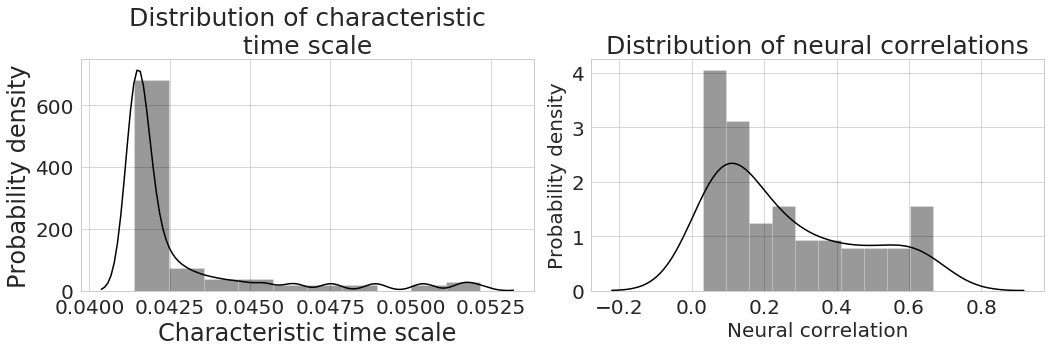

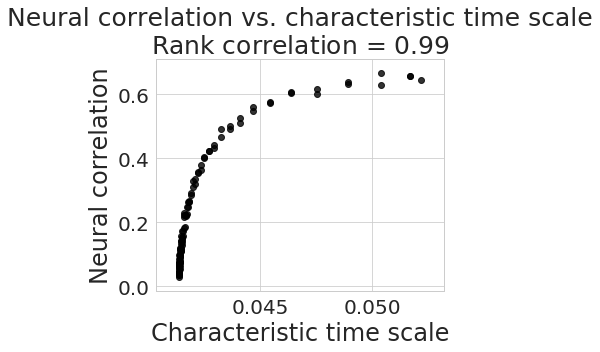

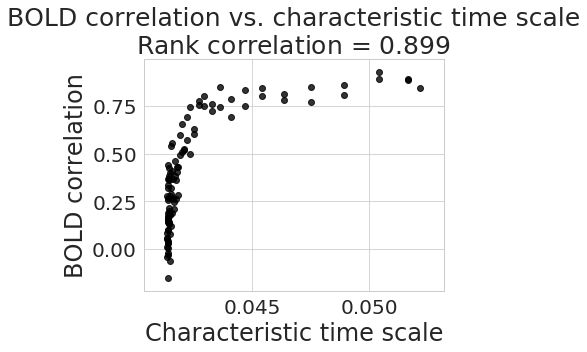

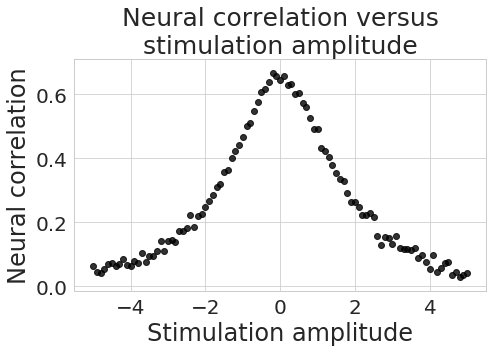

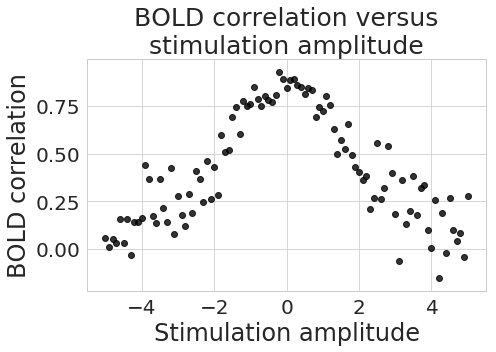

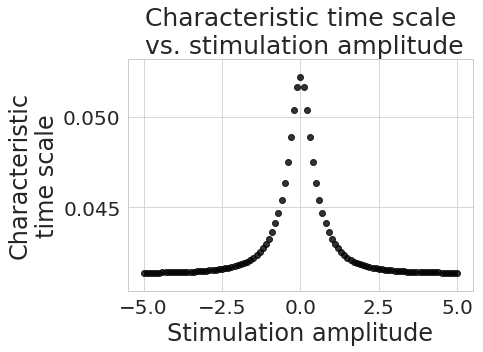

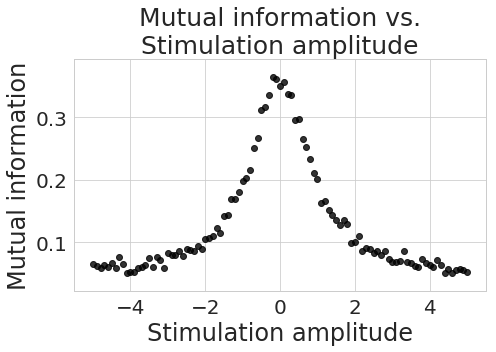

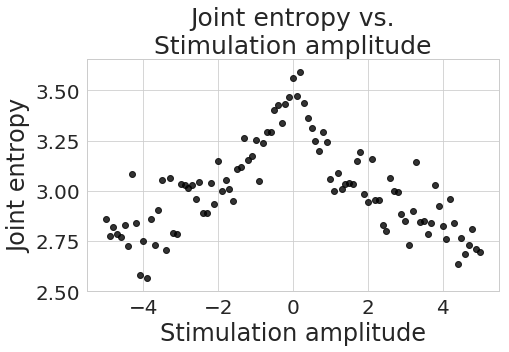

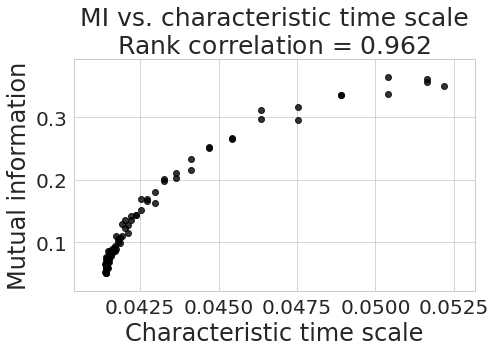

In [12]:
plt.figure(figsize=(15,5));
plt.rc('xtick', labelsize=20);
plt.rc('ytick', labelsize=20);
plt.subplot(121)
plt.title('Distribution of characteristic\ntime scale',fontsize=25);
sns.distplot(eigenvalue_proportion,bins=10,color='k');
plt.xlabel('Characteristic time scale',fontsize=24);
plt.ylabel('Probability density',fontsize=24);

# correlation_values = np.abs(correlation_values)

plt.subplot(122)
sns.distplot(correlation_values,bins=10,color='k');
plt.title('Distribution of neural correlations',fontsize=25);
plt.xlabel('Neural correlation',fontsize=20);
plt.ylabel('Probability density',fontsize=20);
plt.tight_layout();

tmp1 = {}
tmp1['Characteristic time scale'] = np.asarray(eigenvalue_proportion)
tmp1['Neural correlation'] = np.asarray(correlation_values)
tmp1 = pd.DataFrame(tmp1)
plt.figure(figsize=(7,5));
sns.regplot('Characteristic time scale','Neural correlation',tmp1, color='k', fit_reg=False, order=1);
plt.xlabel('Characteristic time scale',fontsize=24);
plt.ylabel('Neural correlation',fontsize=24);
tmp_pearsonr = round(stats.pearsonr(correlation_values,eigenvalue_proportion)[0],3)
tmp_spearmanr = round(stats.spearmanr(correlation_values,eigenvalue_proportion)[0],3)
plt.title('Neural correlation vs. characteristic time scale\nRank correlation = $' + str(tmp_spearmanr) + '$', 
          y=1.00,fontsize=25);
plt.rc('xtick', labelsize=20);
plt.rc('ytick', labelsize=20);
plt.xlim([np.min(eigenvalue_proportion)-.001,np.max(eigenvalue_proportion)+.001])
plt.tight_layout();
#plt.savefig('Analysis5e_2DGroupModel_CharTimeScale_vs_FC.pdf')

tmp1 = {}
tmp1['Characteristic time scale'] = np.asarray(eigenvalue_proportion)
tmp1['BOLD correlation'] = np.asarray(correlation_bold)
tmp1 = pd.DataFrame(tmp1)
plt.figure(figsize=(7,5));
sns.regplot('Characteristic time scale','BOLD correlation',tmp1, color='k', fit_reg=False, order=1);
plt.xlabel('Characteristic time scale',fontsize=24);
plt.ylabel('BOLD correlation',fontsize=24);
tmp_pearsonr = round(stats.pearsonr(correlation_bold,eigenvalue_proportion)[0],3)
tmp_spearmanr = round(stats.spearmanr(correlation_bold,eigenvalue_proportion)[0],3)
plt.title('BOLD correlation vs. characteristic time scale\nRank correlation = $' + str(tmp_spearmanr) + '$', 
          y=1.00,fontsize=25);
plt.rc('xtick', labelsize=20);
plt.rc('ytick', labelsize=20);
plt.xlim([np.min(eigenvalue_proportion)-.001,np.max(eigenvalue_proportion)+.001])
plt.tight_layout();

plt.figure(figsize=(7,5));
tmp1 = {}
tmp1['Stimulation amplitude'] = stim_range
tmp1['Neural correlation'] = correlation_values
tmp1 = pd.DataFrame(tmp1)
sns.regplot('Stimulation amplitude','Neural correlation',tmp1, color='k',fit_reg=False);
plt.xlabel('Stimulation amplitude',fontsize=24);
plt.ylabel('Neural correlation',fontsize=24);
tmp_pearsonr = round(stats.pearsonr(correlation_values,stim_range)[0],3)
tmp_spearmanr = round(stats.spearmanr(correlation_values,stim_range)[0],3)
plt.title('Neural correlation versus\nstimulation amplitude', 
          y=1.00,fontsize=25);
plt.rc('xtick', labelsize=20);
plt.rc('ytick', labelsize=20);
plt.tight_layout();
#plt.savefig('Analysis5e_2DGroupModel_StimAmp_vs_FC.pdf')


plt.figure(figsize=(7,5));
tmp1 = {}
tmp1['Stimulation amplitude'] = stim_range
tmp1['BOLD correlation'] = correlation_bold
tmp1 = pd.DataFrame(tmp1)
sns.regplot('Stimulation amplitude','BOLD correlation',tmp1, color='k',fit_reg=False);
plt.xlabel('Stimulation amplitude',fontsize=24);
plt.ylabel('BOLD correlation',fontsize=24);
tmp_pearsonr = round(stats.pearsonr(correlation_bold,stim_range)[0],3)
tmp_spearmanr = round(stats.spearmanr(correlation_bold,stim_range)[0],3)
plt.title('BOLD correlation versus\nstimulation amplitude', 
          y=1.00,fontsize=25);
plt.rc('xtick', labelsize=20);
plt.rc('ytick', labelsize=20);
plt.tight_layout();
plt.savefig('Analysis5e_2DGroupModel_StimAmp_vs_BOLDFC.pdf')


plt.figure(figsize=(7,5));
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
tmp2 = {}
tmp2['Stimulation amplitude'] = stim_range
tmp2['Eigenvalue proportion'] = eigenvalue_proportion
tmp2 = pd.DataFrame(tmp2)
sns.regplot('Stimulation amplitude','Eigenvalue proportion',tmp2, color='k',fit_reg=False);
plt.xlabel('Stimulation amplitude',fontsize=24);
plt.ylabel('Characteristic\ntime scale',fontsize=24);
tmp_pearsonr = round(stats.pearsonr(eigenvalue_proportion,stim_range)[0],3)
tmp_spearmanr = round(stats.spearmanr(eigenvalue_proportion,stim_range)[0],3)
plt.title('Characteristic time scale\n vs. stimulation amplitude', 
          y=1.00,fontsize=25);
plt.ylim([np.min(eigenvalue_proportion)-.001,np.max(eigenvalue_proportion)+.001])
plt.tight_layout();
#plt.savefig('Analysis5e_2DGroupModel_StimAmp_vs_CharTimeScale.pdf')

tmp1 = {}
tmp1['Stimulation amplitude'] = stim_range
tmp1['Mutual information'] = np.asarray(mutualinfo)
tmp1 = pd.DataFrame(tmp1)
plt.figure(figsize=(7,5));
sns.regplot('Stimulation amplitude','Mutual information',tmp1, color='k', fit_reg=False, order=1);
plt.xlabel('Stimulation amplitude',fontsize=24);
plt.ylabel('Mutual information',fontsize=24);
plt.title('Mutual information vs.\nStimulation amplitude', 
          y=1.00,fontsize=25);
plt.rc('xtick', labelsize=20);
plt.rc('ytick', labelsize=20);
plt.tight_layout();
# plt.savefig('Analysis5e_2DGroupModel_CharTimeScale_vs_MI.pdf')

tmp1 = {}
tmp1['Stimulation amplitude'] = stim_range
tmp1['Joint entropy'] = np.asarray(jointentropy)
tmp1 = pd.DataFrame(tmp1)
plt.figure(figsize=(7,5));
sns.regplot('Stimulation amplitude','Joint entropy',tmp1, color='k', fit_reg=False, order=1);
plt.xlabel('Stimulation amplitude',fontsize=24);
plt.ylabel('Joint entropy',fontsize=24);
plt.title('Joint entropy vs.\nStimulation amplitude', 
          y=1.00,fontsize=25);
plt.rc('xtick', labelsize=20);
plt.rc('ytick', labelsize=20);
plt.tight_layout();
# plt.savefig('Analysis5e_2DGroupModel_StimAmp_vs_JointEntropy.pdf')

tmp1 = {}
tmp1['Characteristic time scale'] = np.asarray(eigenvalue_proportion)
tmp1['Mutual information'] = np.asarray(mutualinfo)
tmp1 = pd.DataFrame(tmp1)
plt.figure(figsize=(7,5));
sns.regplot('Characteristic time scale','Mutual information',tmp1, color='k', fit_reg=False, order=1);
plt.xlabel('Characteristic time scale',fontsize=24);
plt.ylabel('Mutual information',fontsize=24);
tmp_pearsonr = round(stats.pearsonr(mutualinfo,eigenvalue_proportion)[0],3)
tmp_spearmanr = round(stats.spearmanr(mutualinfo,eigenvalue_proportion)[0],3)
plt.title('MI vs. characteristic time scale\nRank correlation = $' + str(tmp_spearmanr) + '$', 
          y=1.00,fontsize=25);
plt.rc('xtick', labelsize=20);
plt.rc('ytick', labelsize=20);
plt.xlim([np.min(eigenvalue_proportion)-.001,np.max(eigenvalue_proportion)+.001])
plt.tight_layout();
# plt.savefig('Analysis5e_2DGroupModel_CharTimeScale_vs_FC.pdf')



## Include analysis with rank correlation

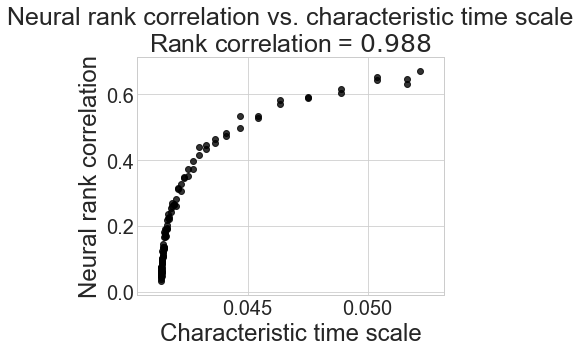

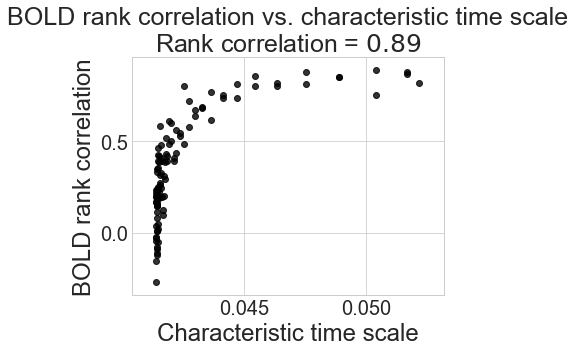

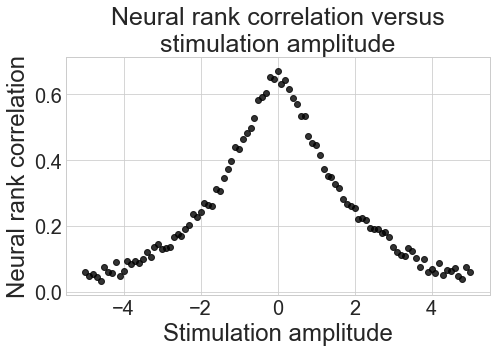

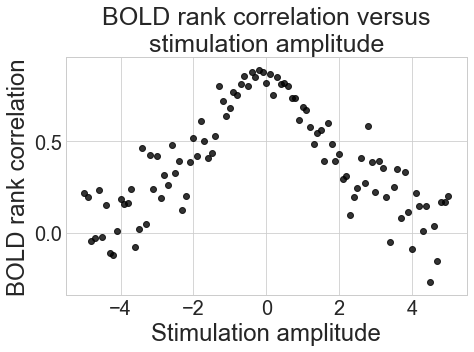

In [6]:
tmp1 = {}
tmp1['Characteristic time scale'] = np.asarray(eigenvalue_proportion)
tmp1['Neural rank correlation'] = np.asarray(rankcorr_values)
tmp1 = pd.DataFrame(tmp1)
plt.figure(figsize=(7,5));
sns.regplot('Characteristic time scale','Neural rank correlation',tmp1, color='k', fit_reg=False, order=1);
plt.xlabel('Characteristic time scale',fontsize=24);
plt.ylabel('Neural rank correlation',fontsize=24);
tmp_pearsonr = round(stats.pearsonr(rankcorr_values,eigenvalue_proportion)[0],3)
tmp_spearmanr = round(stats.spearmanr(rankcorr_values,eigenvalue_proportion)[0],3)
plt.title('Neural rank correlation vs. characteristic time scale\nRank correlation = $' + str(tmp_spearmanr) + '$', 
          y=1.00,fontsize=25);
plt.rc('xtick', labelsize=20);
plt.rc('ytick', labelsize=20);
plt.xlim([np.min(eigenvalue_proportion)-.001,np.max(eigenvalue_proportion)+.001])
plt.tight_layout();
#plt.savefig('Analysis5e_2DGroupModel_CharTimeScale_vs_RankFC.pdf')

tmp1 = {}
tmp1['Characteristic time scale'] = np.asarray(eigenvalue_proportion)
tmp1['BOLD rank correlation'] = np.asarray(rankcorr_bold)
tmp1 = pd.DataFrame(tmp1)
plt.figure(figsize=(7,5));
sns.regplot('Characteristic time scale','BOLD rank correlation',tmp1, color='k', fit_reg=False, order=1);
plt.xlabel('Characteristic time scale',fontsize=24);
plt.ylabel('BOLD rank correlation',fontsize=24);
tmp_pearsonr = round(stats.pearsonr(rankcorr_bold,eigenvalue_proportion)[0],3)
tmp_spearmanr = round(stats.spearmanr(rankcorr_bold,eigenvalue_proportion)[0],3)
plt.title('BOLD rank correlation vs. characteristic time scale\nRank correlation = $' + str(tmp_spearmanr) + '$', 
          y=1.00,fontsize=25);
plt.rc('xtick', labelsize=20);
plt.rc('ytick', labelsize=20);
plt.xlim([np.min(eigenvalue_proportion)-.001,np.max(eigenvalue_proportion)+.001])
plt.tight_layout();

plt.figure(figsize=(7,5));
tmp1 = {}
tmp1['Stimulation amplitude'] = stim_range
tmp1['Neural rank correlation'] = rankcorr_values
tmp1 = pd.DataFrame(tmp1)
sns.regplot('Stimulation amplitude','Neural rank correlation',tmp1, color='k',fit_reg=False);
plt.xlabel('Stimulation amplitude',fontsize=24);
plt.ylabel('Neural rank correlation',fontsize=24);
tmp_pearsonr = round(stats.pearsonr(rankcorr_values,stim_range)[0],3)
tmp_spearmanr = round(stats.spearmanr(rankcorr_values,stim_range)[0],3)
plt.title('Neural rank correlation versus\nstimulation amplitude', 
          y=1.00,fontsize=25);
plt.rc('xtick', labelsize=20);
plt.rc('ytick', labelsize=20);
plt.tight_layout();
#plt.savefig('Analysis5e_2DGroupModel_StimAmp_vs_RankFC.pdf')


plt.figure(figsize=(7,5));
tmp1 = {}
tmp1['Stimulation amplitude'] = stim_range
tmp1['BOLD rank correlation'] = rankcorr_bold
tmp1 = pd.DataFrame(tmp1)
sns.regplot('Stimulation amplitude','BOLD rank correlation',tmp1, color='k',fit_reg=False);
plt.xlabel('Stimulation amplitude',fontsize=24);
plt.ylabel('BOLD rank correlation',fontsize=24);
tmp_pearsonr = round(stats.pearsonr(rankcorr_bold,stim_range)[0],3)
tmp_spearmanr = round(stats.spearmanr(rankcorr_bold,stim_range)[0],3)
plt.title('BOLD rank correlation versus\nstimulation amplitude', 
          y=1.00,fontsize=25);
plt.rc('xtick', labelsize=20);
plt.rc('ytick', labelsize=20);
plt.tight_layout();
plt.savefig('Analysis5e_2DGroupModel_StimAmp_vs_BOLDRankFC.pdf')
